In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import copy
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import svm
from random import randint
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

DATA PREPARATION

In [2]:
df = pd.read_csv("salju_train.csv")                                             #Reading data set
df

,id,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,1,01/06/2014,C4,10.4,15.5,4.8,NaN,NaN,WSW,24.0,NaN,WSW,0.0,13.0,78.0,76.0,1020.1,1018.5,NaN,NaN,13.1,15.0,Ya,Tidak
1,2,15/07/2014,C10,9.0,17.0,8.0,2.6,7.4,NaN,NaN,SW,WNW,13.0,20.0,80.0,61.0,1015.2,1014.6,7.0,5.0,11.9,15.5,Ya,Ya
2,3,16/02/2011,C46,18.2,32.0,0.0,NaN,NaN,ESE,44.0,SE,SE,15.0,26.0,62.0,42.0,NaN,NaN,NaN,NaN,23.8,29.6,Tidak,Tidak
3,4,08/08/2012,C36,7.3,24.5,0.0,8.4,10.4,SSW,54.0,N,SW,13.0,19.0,25.0,17.0,1019.2,1016.9,1.0,7.0,15.3,23.2,Tidak,Tidak
4,5,29/10/2016,C7,5.9,20.3,0.0,3.6,12.6,N,37.0,NNW,ESE,22.0,19.0,55.0,48.0,1019.7,1014.7,2.0,6.0,12.4,18.1,Tidak,Tidak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109090,109091,31/01/2009,C38,20.1,23.7,0.0,7.2,8.9,ESE,43.0,SE,ESE,24.0,26.0,74.0,70.0,1019.3,1017.6,4.0,6.0,22.0,22.1,Tidak,Ya
109091,109092,03/11/2010,C16,15.7,25.2,0.0,NaN,NaN,SSE,37.0,SSE,E,28.0,19.0,52.0,52.0,1018.4,1016.2,NaN,NaN,23.8,24.4,Tidak,Ya
109092,109093,11/11/2010,C17,7.5,20.4,1.6,NaN,NaN,NW,33.0,N,NW,4.0,13.0,92.0,51.0,1014.5,1010.6,NaN,NaN,12.6,19.8,Ya,Tidak
109093,109094,16/04/2012,C11,10.8,29.8,0.0,7.8,11.2,E,48.0,ESE,SE,13.0,26.0,35.0,18.0,1020.0,1015.8,0.0,1.0,21.7,29.2,Tidak,Tidak


NULL CHECKING

In [3]:
df.info()                                                                       #Null checking

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109095 entries, 0 to 109094
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        109095 non-null  int64  
 1   Tanggal                   109095 non-null  object 
 2   KodeLokasi                109095 non-null  object 
 3   SuhuMin                   107973 non-null  float64
 4   SuhuMax                   108166 non-null  float64
 5   Hujan                     106664 non-null  float64
 6   Penguapan                 62071 non-null   float64
 7   SinarMatahari             56716 non-null   float64
 8   ArahAnginTerkencang       101351 non-null  object 
 9   KecepatanAnginTerkencang  101399 non-null  float64
 10  ArahAngin9am              101172 non-null  object 
 11  ArahAngin3pm              105898 non-null  object 
 12  KecepatanAngin9am         107742 non-null  float64
 13  KecepatanAngin3pm         106792 non-null  f

DUPLICATE CHECKING

In [4]:
df.duplicated().sum()                                                           #Duplicate checking

0

INPUT MISSING VALUES

In [5]:
df.fillna(df.mean(), inplace=True)                                              #Numeric is filled with mean
df = df.fillna(df.mode().iloc[0])                                               #STRING is filled with the most frequently occurring value for the attribute
df

,id,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,1,01/06/2014,C4,10.4,15.5,4.8,5.46244,7.599527,WSW,24.000000,N,WSW,0.0,13.0,78.0,76.0,1020.10000,1018.500000,4.450893,4.51614,13.1,15.0,Ya,Tidak
1,2,15/07/2014,C10,9.0,17.0,8.0,2.60000,7.400000,W,40.032002,SW,WNW,13.0,20.0,80.0,61.0,1015.20000,1014.600000,7.000000,5.00000,11.9,15.5,Ya,Ya
2,3,16/02/2011,C46,18.2,32.0,0.0,5.46244,7.599527,ESE,44.000000,SE,SE,15.0,26.0,62.0,42.0,1017.64708,1015.253117,4.450893,4.51614,23.8,29.6,Tidak,Tidak
3,4,08/08/2012,C36,7.3,24.5,0.0,8.40000,10.400000,SSW,54.000000,N,SW,13.0,19.0,25.0,17.0,1019.20000,1016.900000,1.000000,7.00000,15.3,23.2,Tidak,Tidak
4,5,29/10/2016,C7,5.9,20.3,0.0,3.60000,12.600000,N,37.000000,NNW,ESE,22.0,19.0,55.0,48.0,1019.70000,1014.700000,2.000000,6.00000,12.4,18.1,Tidak,Tidak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109090,109091,31/01/2009,C38,20.1,23.7,0.0,7.20000,8.900000,ESE,43.000000,SE,ESE,24.0,26.0,74.0,70.0,1019.30000,1017.600000,4.000000,6.00000,22.0,22.1,Tidak,Ya
109091,109092,03/11/2010,C16,15.7,25.2,0.0,5.46244,7.599527,SSE,37.000000,SSE,E,28.0,19.0,52.0,52.0,1018.40000,1016.200000,4.450893,4.51614,23.8,24.4,Tidak,Ya
109092,109093,11/11/2010,C17,7.5,20.4,1.6,5.46244,7.599527,NW,33.000000,N,NW,4.0,13.0,92.0,51.0,1014.50000,1010.600000,4.450893,4.51614,12.6,19.8,Ya,Tidak
109093,109094,16/04/2012,C11,10.8,29.8,0.0,7.80000,11.200000,E,48.000000,ESE,SE,13.0,26.0,35.0,18.0,1020.00000,1015.800000,0.000000,1.00000,21.7,29.2,Tidak,Tidak


CHOOSE ATRIBUT

In [6]:
data = pd.DataFrame(columns = ['Hujan', 'SinarMatahari', 'KecepatanAngin3pm', 'Kelembaban3pm', 'Awan3pm', 'Suhu3pm'])     #Choosing 'Hujan', 'SinarMatahari', 'KecepatanAngin3pm', 'Kelembaban3pm', 'Awan3pm', 'Suhu3pm' as potential attributes 
data['Hujan'] = df['Hujan']
data['SinarMatahari'] = df['SinarMatahari']
data['KecepatanAngin3pm'] = df['KecepatanAngin3pm']
data['Kelembaban3pm'] = df['Kelembaban3pm']
data['Awan3pm'] = df['Awan3pm']
data['Suhu3pm'] = df['Suhu3pm']
data

,Hujan,SinarMatahari,KecepatanAngin3pm,Kelembaban3pm,Awan3pm,Suhu3pm
0,4.8,7.599527,13.0,76.0,4.51614,15.0
1,8.0,7.400000,20.0,61.0,5.00000,15.5
2,0.0,7.599527,26.0,42.0,4.51614,29.6
3,0.0,10.400000,19.0,17.0,7.00000,23.2
4,0.0,12.600000,19.0,48.0,6.00000,18.1
...,...,...,...,...,...,...
109090,0.0,8.900000,26.0,70.0,6.00000,22.1
109091,0.0,7.599527,19.0,52.0,4.51614,24.4
109092,1.6,7.599527,13.0,51.0,4.51614,19.8
109093,0.0,11.200000,26.0,18.0,1.00000,29.2


FINDING OUTLIER

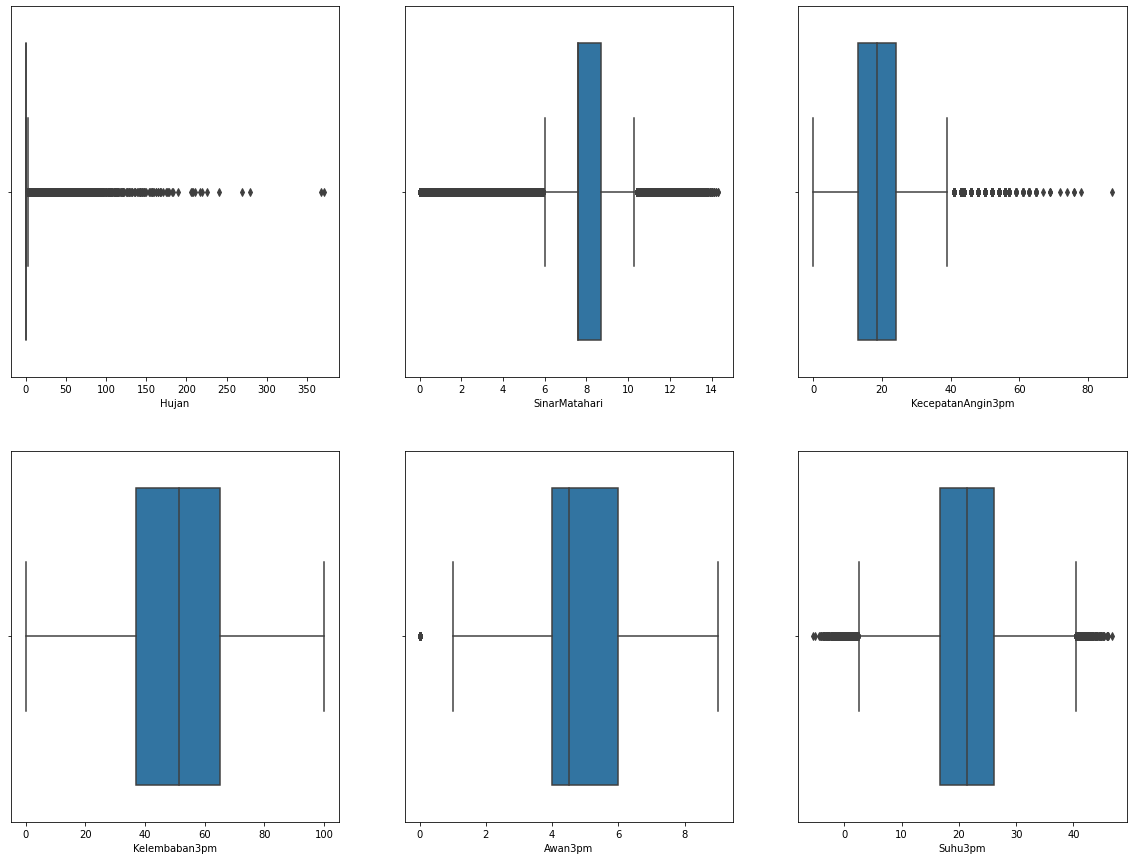

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 15))                    
for i, ax in zip(data.columns, axes.flat):                                      #Displaying boxplots of selected attributes to view outliers
  sns.boxplot(x=data[i], ax=ax)
plt.show()

FINDING DISTRIBUTION

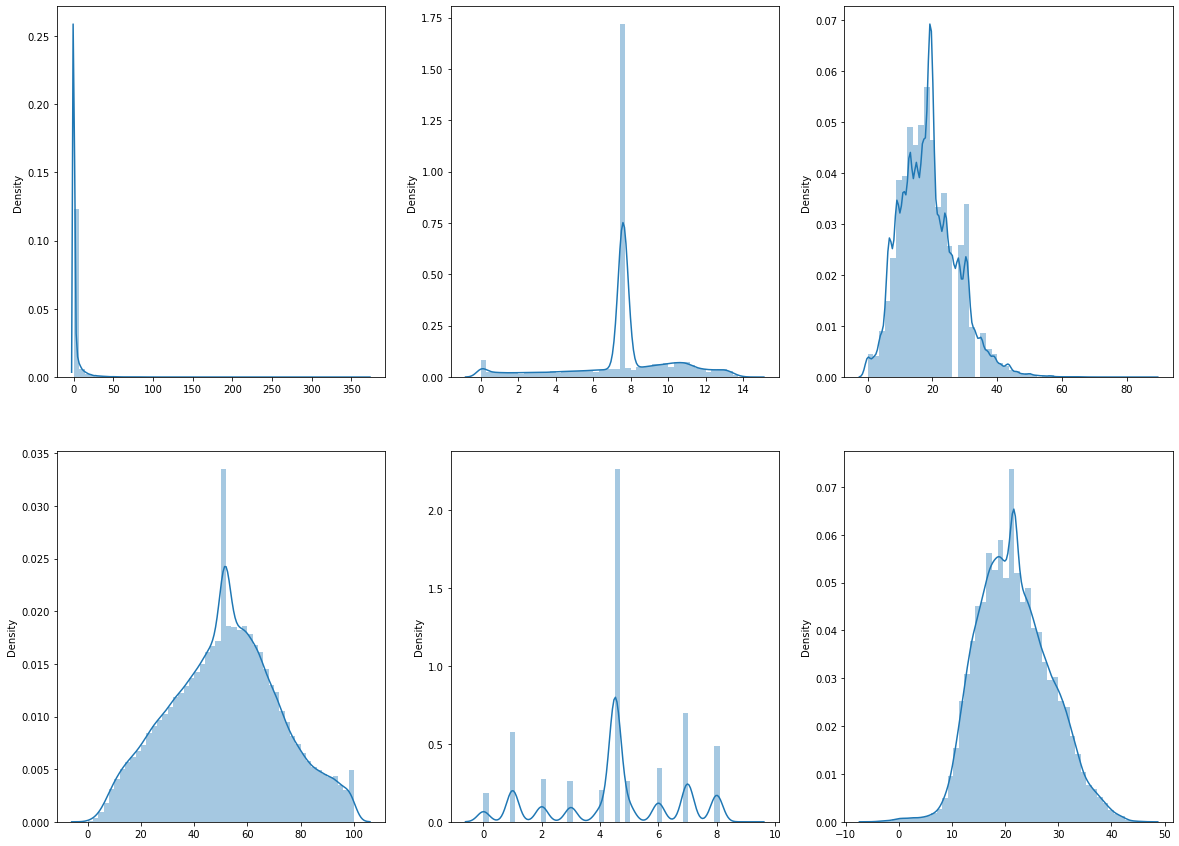

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 15))
for i, ax in zip(data.columns, axes.flat):                                      #Displaying the distribution of selected attributes to see the height of the density
  sns.distplot(x=data[i], hist=True, ax=ax)
plt.show()

FINDING CORRELATION

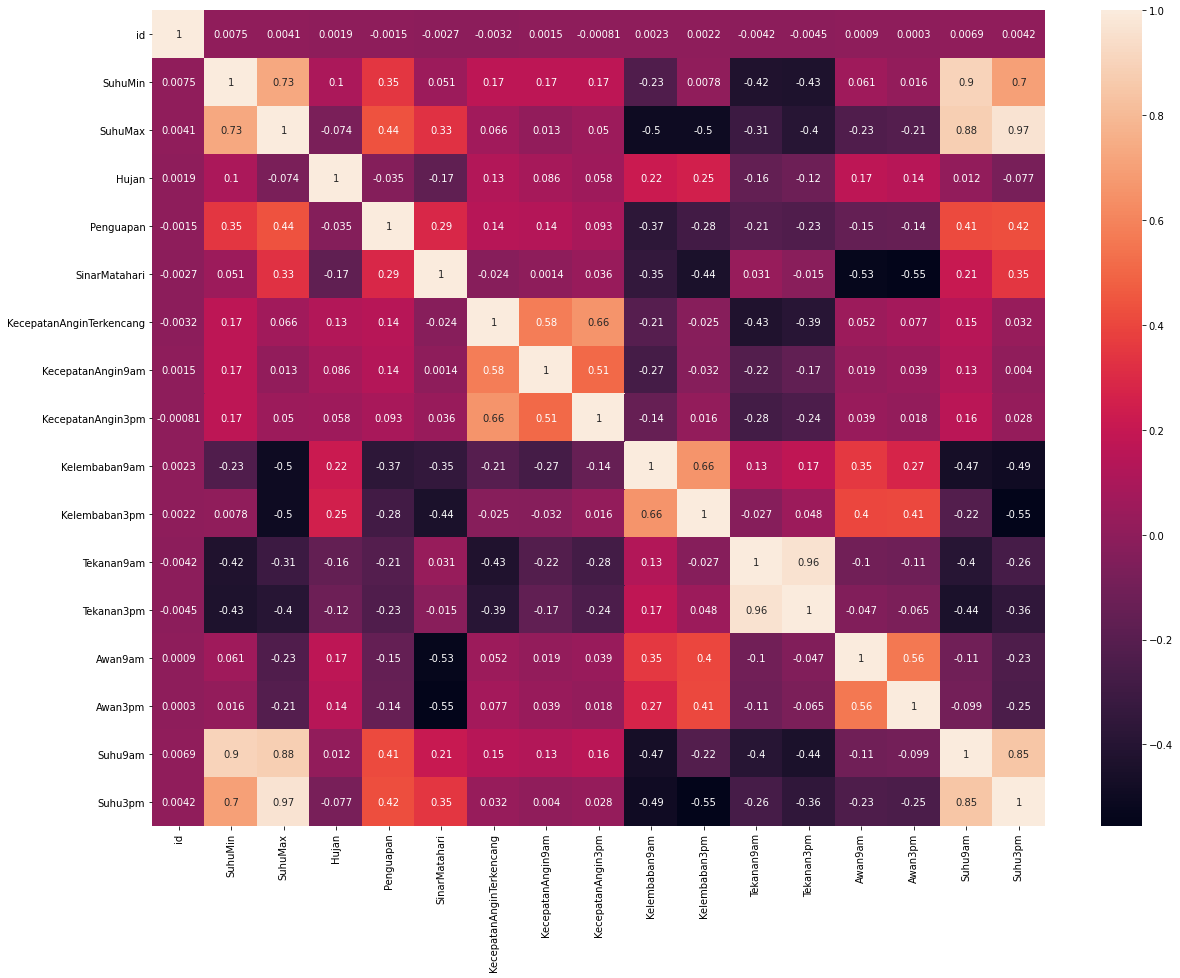

In [9]:
corr = df.corr()                                                                #Displaying the heatmap to see the correlation between attributes

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True)

CEK NULL

In [10]:
df.isnull().sum()                                                               #checking null again to make sure there are no null values for each attribute

id                          0
Tanggal                     0
KodeLokasi                  0
SuhuMin                     0
SuhuMax                     0
Hujan                       0
Penguapan                   0
SinarMatahari               0
ArahAnginTerkencang         0
KecepatanAnginTerkencang    0
ArahAngin9am                0
ArahAngin3pm                0
KecepatanAngin9am           0
KecepatanAngin3pm           0
Kelembaban9am               0
Kelembaban3pm               0
Tekanan9am                  0
Tekanan3pm                  0
Awan9am                     0
Awan3pm                     0
Suhu9am                     0
Suhu3pm                     0
BersaljuHariIni             0
BersaljuBesok               0
dtype: int64

SCALLING

In [11]:
scaler = MinMaxScaler()                                                                                   #Initialise the Scaler 
data.iloc[0:len(data),[0,1,2,3,4,5]] = scaler.fit_transform(data.iloc[0:len(data),[0,1,2,3,4,5]])         #Making numerical data in the dataset have the same range of values
data

,Hujan,SinarMatahari,KecepatanAngin3pm,Kelembaban3pm,Awan3pm,Suhu3pm
0,0.012938,0.531435,0.149425,0.76,0.501793,0.391555
1,0.021563,0.517483,0.229885,0.61,0.555556,0.401152
2,0.000000,0.531435,0.298851,0.42,0.501793,0.671785
3,0.000000,0.727273,0.218391,0.17,0.777778,0.548944
4,0.000000,0.881119,0.218391,0.48,0.666667,0.451056
...,...,...,...,...,...,...
109090,0.000000,0.622378,0.298851,0.70,0.666667,0.527831
109091,0.000000,0.531435,0.218391,0.52,0.501793,0.571977
109092,0.004313,0.531435,0.149425,0.51,0.501793,0.483685
109093,0.000000,0.783217,0.298851,0.18,0.111111,0.664107


SAVE PREPROCESSING DATA

In [16]:
data.to_csv(r'D:\Semester 6\MACHINE LEARNING\salju\data_preprocessing.xls', index=False, header=True)                     #Saving new datasett from the choosen atribut

CLUSTERING

CLUSTERING K=2

FUNCTION FOR 2 ATTRIBUTES AND K=2

In [ ]:
def getParameter(row):                                                          #Function for 2 attributes and K=2
    return [row['Hujan'],row['SinarMatahari'],0]

def getParameter0(row):                                                         #Function for 2 attributes and K=2
    return [row['Kelembaban3pm'],row['Suhu3pm'],0]

def getParameter1(row):                                                         #Function for 3 attributes and K=2
    return [row['Hujan'],row['SinarMatahari'],row['Awan3pm'],0]

def getParameter2(row):                                                         #Function for 3 attributes and K=2
    return [row['KecepatanAngin3pm'],row['Kelembaban3pm'],row['Suhu3pm'],0]

silhouette_scores = []                                                          #New variable to collect sillhouette score from every experiments

In [ ]:
def getEuclideanK2(row, a1, a2):                                                #Euclidean function for 2 attributes
    euc1 = math.sqrt((row[0]-a1[0])**2 + (row[1]-a1[1])**2)
    euc2 = math.sqrt((row[0]-a2[0])**2 + (row[1]-a2[1])**2)
    return euc1, euc2                                                           

def getClusterK2(euc1, euc2):                                                   #Clustering function for2 attributes
    near = min(euc1, euc2)
    if euc1 == near:
        return 1
    elif euc2 == near:
        return 2
    
def getNewCentroidK2(parameter):                                                #Function to find centroid for 2 attributes
    sum1 = [0,0]
    sum2 = [0,0]
    count1 = 0
    count2 = 0
    for i in parameter:
        if i[2] == 1:
            sum1[0] += i[0]
            sum1[1] += i[1]
            count1 += 1
        elif i[2] == 2:
            sum2[0] += i[0]
            sum2[1] += i[1]
            count2 += 1
          
    a1 = [sum1[0]/count1, sum1[1]/count1]
    a2 = [sum2[0]/count2, sum2[1]/count2]
    
    return a1, a2

ATTRIBUTES : Hujan & Sinar Matahari

In [ ]:
parameter = data.apply(getParameter, axis=1)                                    #Experiment 1 : Using 2 attributes (Hujan & Sinar Matahari) and K=2

idxa1 = randint(0,len(parameter))
idxa2 = randint(0,len(parameter))
while idxa2 == idxa1:
    idxa2 = randint(0,len(parameter))

a1_1 = parameter[idxa1][0:2]
a1_2 = parameter[idxa2][0:2]

while True:
    for i in parameter:
        euc1, euc2 = getEuclideanK2(i, a1_1, a1_2)
        i[2] = getClusterK2(euc1, euc2)
    prev_a1 = copy.deepcopy(a1_1)
    prev_a2 = copy.deepcopy(a1_2)
    
    a1_1, a1_2 = getNewCentroidK2(parameter)
    if prev_a1 == a1_1 and prev_a2 == a1_2:
        break

att1 = []
cluster1 = []
att1_1_1 = []
att1_1_2 = []

att2_1_1 = []
att2_1_2 = []

for i in parameter:
    att1.append([i[0],i[1]])
    cluster1.append(i[2])
    if i[2] == 1: 
        att1_1_1.append(i[0]) 
        att1_1_2.append(i[1]) 
    else:
        att2_1_1.append(i[0])
        att2_1_2.append(i[1])
        
score1 = silhouette_score(att1, cluster1)                                       #Assigning clustering and sillhouette score
print("Silhoutte Score = ", score1)
silhouette_scores.append({'K':2,'Attributes':'Hujan, SinarMatahari','Silhouette Score':score1})       #Assigning result for evaluation viewing

Silhoutte Score =  0.695794290732048


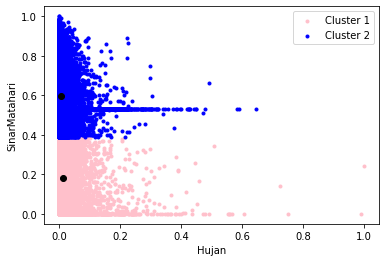

In [ ]:
plt.scatter(att1_1_1,att1_1_2,color='pink', marker='.', label='Cluster 1')      #Label 1
plt.scatter(a1_1[0],a1_1[1],color='black',marker='o')

plt.scatter(att2_1_1, att2_1_2,color='blue', marker='.', label='Cluster 2')     #Label 2
plt.scatter(a1_2[0],a1_2[1],color='black',marker='o')

plt.xlabel('Hujan')
plt.ylabel('SinarMatahari')

plt.legend()

plt.show()

Attributes : Kelembaban3pm & Suhu3pm

In [ ]:
parameter = data.apply(getParameter0, axis=1)                                   #Experiment 2 : Using 2 attributes (Kelembaban3pm & Suhu3pm) and K=2

idxa1 = randint(0,len(parameter))
idxa2 = randint(0,len(parameter))
while idxa2 == idxa1:
    idxa2 = randint(0,len(parameter))

a2_1 = parameter[idxa1][0:2]
a2_2 = parameter[idxa2][0:2]

while True:
    for i in parameter:
        euc1, euc2 = getEuclideanK2(i, a2_1, a2_2)
        i[2] = getClusterK2(euc1, euc2)
    prev_a1 = copy.deepcopy(a2_1)
    prev_a2 = copy.deepcopy(a2_2)
    
    a2_1, a2_2 = getNewCentroidK2(parameter)
    if prev_a1 == a2_1 and prev_a2 == a2_2:
        break

att2 = []
cluster2 = []
att1_2_1 = []
att1_2_2 = []

att2_2_1 = []
att2_2_2 = []

for i in parameter:
    att2.append([i[0],i[1]])
    cluster2.append(i[2])
    if i[2] == 1: 
        att1_2_1.append(i[0]) 
        att1_2_2.append(i[1]) 
    else:
        att2_2_1.append(i[0])
        att2_2_2.append(i[1])
        
score2 = silhouette_score(att2, cluster2)                                       #Assigning clustering and sillhouette score
print("Silhoutte Score = ", score2)
silhouette_scores.append({'K':2,'Attributes':'Kelembaban3pm, Suhu3pm','Silhouette Score':score2})     #Assigning result for evaluation viewing

Silhoutte Score =  0.4249935775308435


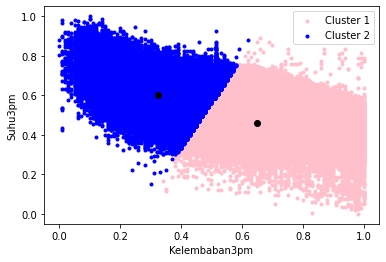

In [ ]:
plt.scatter(att1_2_1,att1_2_2,color='pink', marker='.', label='Cluster 1')      #Label 1
plt.scatter(a2_1[0],a2_1[1],color='black',marker='o')

plt.scatter(att2_2_1, att2_2_2,color='blue', marker='.', label='Cluster 2')     #Label 2
plt.scatter(a2_2[0],a2_2[1],color='black',marker='o')

plt.xlabel('Kelembaban3pm')
plt.ylabel('Suhu3pm')

plt.legend()

plt.show()

FUNCTION FOR 3 ATTRIBUTES K=2

In [ ]:
def getEuclideanK2(row, a1, a2):                                                #Euclidean fuction for 3 attributes and K=2
    euc1 = math.sqrt((row[0]-a1[0])**2 + (row[1]-a1[1])**2 + (row[2]-a1[2])**2)
    euc2 = math.sqrt((row[0]-a2[0])**2 + (row[1]-a2[1])**2 + (row[2]-a2[2])**2)
    return euc1, euc2

def getClusterK2(euc1, euc2):                                                   #Clustering function for 3 attributes and K=2
    near = min(euc1, euc2)
    if euc1 == near:
        return 1
    elif euc2 == near:
        return 2
    
def getNewCentroidK2(parameter):                                                #Function to find centroid for 3 attributes and K=2
    sum1 = [0,0,0]
    sum2 = [0,0,0]
    count1 = 0
    count2 = 0
    for i in parameter:
        if i[3] == 1:
            sum1[0] += i[0]
            sum1[1] += i[1]
            sum1[2] += i[2]
            count1 += 1
        elif i[3] == 2:
            sum2[0] += i[0]
            sum2[1] += i[1]
            sum2[2] += i[2]
            count2 += 1
          
    a1 = [sum1[0]/count1, sum1[1]/count1, sum1[2]/count1]
    a2 = [sum2[0]/count2, sum2[1]/count2, sum2[2]/count2]
    
    return a1, a2

Attributes : Hujan, SinarMatahari, Awan3pm

In [ ]:
parameter = data.apply(getParameter1, axis=1)                                   #Experiment 3 : Using 3 attributes (Hujan, SinarMatahari, & Awan3pm) and K=2

idxa1 = randint(0,len(parameter))
idxa2 = randint(0,len(parameter))
while idxa2 == idxa1:
    idxa2 = randint(0,len(parameter))

a3_1 = parameter[idxa1][0:3]
a3_2 = parameter[idxa2][0:3]

while True:
    for i in parameter:
        euc1, euc2 = getEuclideanK2(i, a3_1, a3_2)
        i[3] = getClusterK2(euc1, euc2)
    prev_a1 = copy.deepcopy(a3_1)
    prev_a2 = copy.deepcopy(a3_2)
    
    a3_1, a3_2 = getNewCentroidK2(parameter)
    if prev_a1 == a3_1 and prev_a2 == a3_2:
        break
att3 = []
cluster3 = []
att3_1_1 = []
att3_1_2 = []
att3_1_3 = []

att3_2_1 = []
att3_2_2 = []
att3_2_3 = []

for i in parameter:
    att3.append([i[0],i[1],i[2]])
    cluster3.append(i[3])
    if i[3] == 1: 
        att3_1_1.append(i[0]) 
        att3_1_2.append(i[1]) 
        att3_1_3.append(i[2]) 
    else:
        att3_2_1.append(i[0])
        att3_2_2.append(i[1])
        att3_2_3.append(i[2])
        
score3 = silhouette_score(att3, cluster3)                                       #Assigning clustering and sillhouette score
print("Silhoutte Score = ", score3)
silhouette_scores.append({'K':2,'Attributes':'Hujan, SinarMatahari, Awan3pm','Silhouette Score':score3})    #Assigning result for evaluation viewing

Silhoutte Score =  0.48077880402561246


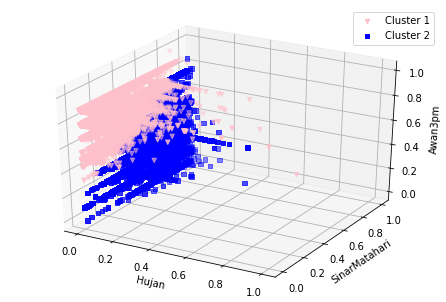

In [ ]:
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter(att3_1_1,att3_1_2,att3_1_3,color='pink', marker='v', label='Cluster 1')        #Label 1
ax.scatter(a3_1[0],a3_1[1],a3_1[2],color='red',marker='o')

ax.scatter(att3_2_1, att3_2_2, att3_2_3,color='blue', marker=',', label='Cluster 2')      #Label 2
ax.scatter(a3_2[0],a3_2[1],a3_2[2],color='red',marker='o')

ax.set_xlabel('Hujan')
ax.set_ylabel('SinarMatahari')
ax.set_zlabel('Awan3pm')

ax.legend()

plt.show()

Attributes : KecepatanAngin3pm, Kelembaban3pm, Suhu3pm

In [ ]:
parameter = data.apply(getParameter2, axis=1)                                   #Experiment 4 : Using 3 attributes (KecepatanAngin3pm, Kelembaban3pm, Suhu3pm) and K=2

idxa1 = randint(0,len(parameter))
idxa2 = randint(0,len(parameter))
while idxa2 == idxa1:
    idxa2 = randint(0,len(parameter))

a4_1 = parameter[idxa1][0:3]
a4_2 = parameter[idxa2][0:3]
while True:
    for i in parameter:
        euc1, euc2 = getEuclideanK2(i, a4_1, a4_2)
        i[3] = getClusterK2(euc1, euc2)
    prev_a1 = copy.deepcopy(a4_1)
    prev_a2 = copy.deepcopy(a4_2)
    
    a1, a2 = getNewCentroidK2(parameter)
    if prev_a1 == a4_1 and prev_a2 == a4_2:
        break

att4 = []
cluster4 = []

att4_1_1 = []
att4_1_2 = []
att4_1_3 = []

att4_2_1 = []
att4_2_2 = []
att4_2_3 = []

for i in parameter:
    cluster4.append(i[3])
    att4.append([i[0],i[1],i[2]])
    if i[3] == 1: 
        att4_1_1.append(i[0]) 
        att4_1_2.append(i[1]) 
        att4_1_3.append(i[2]) 
    else:
        att4_2_1.append(i[0])
        att4_2_2.append(i[1])
        att4_2_3.append(i[2])

score4 = silhouette_score(att4, cluster4)                                       #Assigning clustering and sillhouette score
print("Silhoutte Score = ", score4)
silhouette_scores.append({'K':2,'Attributes':'KecepatanAngin3pm, Kelembaban3pm, Suhu3pm','Silhouette Score':score4})    #Assigning result for evaluation viewing

Silhoutte Score =  0.18902595406116468


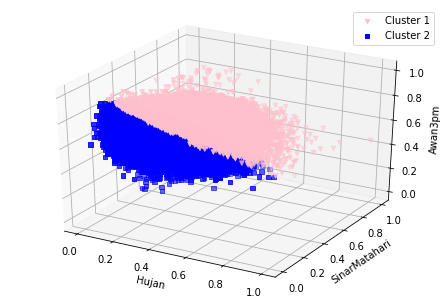

In [ ]:
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter(att4_1_1,att4_1_2,att4_1_3,color='pink', marker='v', label='Cluster 1')          #Label 1
ax.scatter(a4_1[0],a4_1[1],a4_1[2],color='red',marker='o')

ax.scatter(att4_2_1, att4_2_2, att4_2_3,color='blue', marker=',', label='Cluster 2')        #Label 2
ax.scatter(a4_2[0],a4_2[1],a4_2[2],color='red',marker='o')

ax.set_xlabel('Hujan')
ax.set_ylabel('SinarMatahari')
ax.set_zlabel('Awan3pm')

ax.legend()

plt.show()

CLUSTERING K=3

FUNCTION FOR 2 ATTRIBUTES AND K=3

In [ ]:
def getEuclidean(row, a1, a2, a3):                                              #Euclidean fuction for 2 attributes and K=3
    euc1 = math.sqrt((row[0]-a1[0])**2 + (row[1]-a1[1])**2)
    euc2 = math.sqrt((row[0]-a2[0])**2 + (row[1]-a2[1])**2)
    euc3 = math.sqrt((row[0]-a3[0])**2 + (row[1]-a3[1])**2)
    return euc1, euc2, euc3

def getCluster(euc1, euc2, euc3):                                               #Clustering fuction for 2 attributes and K=3
    near = min(euc1, euc2, euc3)
    if euc1 == near:
        return 1
    elif euc2 == near:
        return 2
    else :
        return 3
    
def getNewCentroid(parameter):                                                  #Fuction to find centroid for 2 attributes and K=3
    sum1 = [0,0]
    sum2 = [0,0]
    sum3 = [0,0]
    count1 = 0
    count2 = 0
    count3 = 0
    for i in parameter:
        if i[2] == 1:
            sum1[0] += i[0]
            sum1[1] += i[1]
            count1 += 1
        elif i[2] == 2:
            sum2[0] += i[0]
            sum2[1] += i[1]
            count2 += 1
        else :
            sum3[0] += i[0]
            sum3[1] += i[1]
            count3 += 1
          
    a1 = [sum1[0]/count1, sum1[1]/count1]
    a2 = [sum2[0]/count2, sum2[1]/count2]
    a3 = [sum3[0]/count3, sum3[1]/count3]
    
    return a1, a2, a3

ATTRIBUTES : Hujan & SinarMatahari

In [ ]:
parameter = data.apply(getParameter, axis=1)                                    #Experiment 5 : Using 2 attributes (Hujan & SinarMatahari) and K=3

idxa1 = randint(0,len(parameter))
idxa2 = randint(0,len(parameter))
while idxa2 == idxa1:
    idxa2 = randint(0,len(parameter))
    
idxa3 = randint(0,len(parameter))
while idxa3 == idxa1 or idxa3 == idxa2:
    idxa3 = randint(0,len(parameter))

#ITERASI PERTAMA
a5_1 = parameter[idxa1][0:2]
a5_2 = parameter[idxa2][0:2]
a5_3 = parameter[idxa3][0:2]

while True:
    for i in parameter:
        euc1, euc2, euc3 = getEuclidean(i, a5_1, a5_2, a5_3)
        i[2] = getCluster(euc1, euc2, euc3)
    prev_a1 = copy.deepcopy(a5_1)
    prev_a2 = copy.deepcopy(a5_2)
    prev_a3 = copy.deepcopy(a5_3)
    
    a5_1, a5_2, a5_3 = getNewCentroid(parameter)
    if prev_a1 == a5_1 and prev_a2 == a5_2 and prev_a3 == a5_3:
        break

att5_1_1 = []
att5_1_2 = []

att5_2_1 = []
att5_2_2 = []

att5_3_1 = []
att5_3_2 = []

att5 = []
cluster5 = []

for i in parameter:
    cluster5.append(i[2])
    att5.append([i[0],i[1]])
    if i[2] == 1: 
        att5_1_1.append(i[0]) 
        att5_1_2.append(i[1]) 
    elif i[2] == 2:
        att5_2_1.append(i[0])
        att5_2_2.append(i[1])
    elif i[2] == 3:
        att5_3_1.append(i[0])
        att5_3_2.append(i[1])
        
score5 = silhouette_score(att5, cluster5)                                        #Assigning clustering and sillhouette score
print("Silhoutte Score= ", score5)
silhouette_scores.append({'K':3,'Attributes':'Hujan, SinarMatahari','Silhouette Score':score5})     #Assigning result for evaluation viewing

Silhoutte Score=  0.7267151595792517


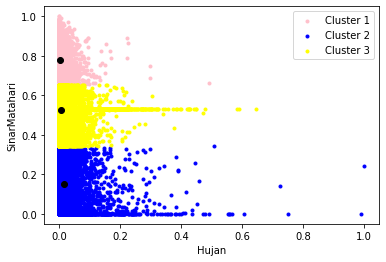

In [ ]:
plt.scatter(att5_1_1,att5_1_2,color='pink', marker='.', label='Cluster 1')      #Label 1
plt.scatter(a5_1[0],a5_1[1],color='black',marker='o')

plt.scatter(att5_2_1, att5_2_2,color='blue', marker='.', label='Cluster 2')     #Label 2
plt.scatter(a5_2[0],a5_2[1],color='black',marker='o')

plt.scatter(att5_3_1, att5_3_2,color='yellow', marker='.', label='Cluster 3')   #Label 3
plt.scatter(a5_3[0],a5_3[1],color='black',marker='o')

plt.xlabel('Hujan')
plt.ylabel('SinarMatahari')

plt.legend()

plt.show()

ATTRIBUTES : Kelembaban3pm & Suhu3pm

In [ ]:
parameter = data.apply(getParameter0, axis=1)                                   #Experiment 6 : Using 2 attributes (Kelembaban3pm & Suhu3pm) and K=3

idxa1 = randint(0,len(parameter))
idxa2 = randint(0,len(parameter))
while idxa2 == idxa1:
    idxa2 = randint(0,len(parameter))
    
idxa3 = randint(0,len(parameter))
while idxa3 == idxa1 or idxa3 == idxa2:
    idxa3 = randint(0,len(parameter))

#ITERASI PERTAMA
a6_1 = parameter[idxa1][0:2]
a6_2 = parameter[idxa2][0:2]
a6_3 = parameter[idxa3][0:2]

while True:
    for i in parameter:
        euc1, euc2, euc3 = getEuclidean(i, a6_1, a6_2, a6_3)
        i[2] = getCluster(euc1, euc2, euc3)
    prev_a1 = copy.deepcopy(a6_1)
    prev_a2 = copy.deepcopy(a6_2)
    prev_a3 = copy.deepcopy(a6_3)
    
    a6_1, a6_2, a6_3 = getNewCentroid(parameter)
    if prev_a1 == a6_1 and prev_a2 == a6_2 and prev_a3 == a6_3:
        break

att6_1_1 = []
att6_1_2 = []

att6_2_1 = []
att6_2_2 = []

att6_3_1 = []
att6_3_2 = []

att6 = []
cluster6 = []

for i in parameter:
    cluster6.append(i[2])
    att6.append([i[0],i[1]])
    if i[2] == 1: 
        att6_1_1.append(i[0]) 
        att6_1_2.append(i[1]) 
    elif i[2] == 2:
        att6_2_1.append(i[0])
        att6_2_2.append(i[1])
    elif i[2] == 3:
        att6_3_1.append(i[0])
        att6_3_2.append(i[1])
        
score6 = silhouette_score(att6, cluster6)                                       #Assigning clustering and sillhouette score
print("Silhoutte Score = ", score6)
silhouette_scores.append({'K':3,'Attributes':'Kelembaban3pm, Suhu3pm','Silhouette Score':score6})     #Assigning result for evaluation viewing

Silhoutte Score =  0.3883292754218714


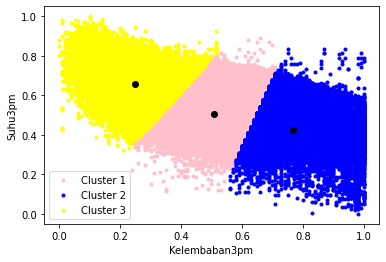

In [ ]:
plt.scatter(att6_1_1,att6_1_2,color='pink', marker='.', label='Cluster 1')      #Label 1
plt.scatter(a6_1[0],a6_1[1],color='black',marker='o')

plt.scatter(att6_2_1, att6_2_2,color='blue', marker='.', label='Cluster 2')     #Label 2
plt.scatter(a6_2[0],a6_2[1],color='black',marker='o')

plt.scatter(att6_3_1, att6_3_2,color='yellow', marker='.', label='Cluster 3')   #Label 3
plt.scatter(a6_3[0],a6_3[1],color='black',marker='o')

plt.xlabel('Kelembaban3pm')
plt.ylabel('Suhu3pm')

plt.legend()

plt.show()

FUNCTION FOR 3 ATTRIBUTES AND K=3

In [ ]:
def getEuclidean(row, a1, a2, a3):                                              #Eulidean function for 3 attributes and K=3
    euc1 = math.sqrt((row[0]-a1[0])**2 + (row[1]-a1[1])**2 + (row[2]-a1[2])**2)
    euc2 = math.sqrt((row[0]-a2[0])**2 + (row[1]-a2[1])**2 + (row[2]-a2[2])**2)
    euc3 = math.sqrt((row[0]-a3[0])**2 + (row[1]-a3[1])**2 + (row[2]-a3[2])**2)
    return euc1, euc2, euc3

def getCluster(euc1, euc2, euc3):                                               #Clustering function for 3 attributes and K=3
    near = min(euc1, euc2, euc3)
    if euc1 == near:
        return 1
    elif euc2 == near:
        return 2
    else :
        return 3

def getNewCentroid(parameter):                                                  #Function to find centroid for 3 attributes and K=3
    sum1 = [0,0,0]
    sum2 = [0,0,0]
    sum3 = [0,0,0]
    count1 = 0
    count2 = 0
    count3 = 0
    for i in parameter:
        if i[3] == 1:
            sum1[0] += i[0]
            sum1[1] += i[1]
            sum1[2] += i[2]
            count1 += 1
        elif i[3] == 2:
            sum2[0] += i[0]
            sum2[1] += i[1]
            sum2[2] += i[2]
            count2 += 1
        else :
            sum3[0] += i[0]
            sum3[1] += i[1]
            sum3[2] += i[2]
            count3 += 1
          
    a1 = [sum1[0]/count1, sum1[1]/count1, sum1[2]/count1]
    a2 = [sum2[0]/count2, sum2[1]/count2, sum2[2]/count2]
    a3 = [sum3[0]/count3, sum3[1]/count3, sum3[2]/count3]
    
    return a1, a2, a3

Attributes : Hujan, SinarMatahari, Awan3pm

In [ ]:
parameter = data.apply(getParameter1, axis=1)                                   #Experiment 7 : Using 3 attributes (Hujan, SinarMatahari, & Awan3pm) and K=3

idxa1 = randint(0,len(parameter))
idxa2 = randint(0,len(parameter))
while idxa2 == idxa1:
    idxa2 = randint(0,len(parameter))
    
idxa3 = randint(0,len(parameter))
while idxa3 == idxa1 or idxa3 == idxa2:
    idxa3 = randint(0,len(parameter))

#ITERASI PERTAMA
a7_1 = parameter[idxa1][0:3]
a7_2 = parameter[idxa2][0:3]
a7_3 = parameter[idxa3][0:3]

while True:
    for i in parameter:
        euc1, euc2, euc3 = getEuclidean(i, a7_1, a7_2, a7_3)
        i[3] = getCluster(euc1, euc2, euc3)
    prev_a1 = copy.deepcopy(a7_1)
    prev_a2 = copy.deepcopy(a7_2)
    prev_a3 = copy.deepcopy(a7_3)
    
    a7_1, a7_2, a7_3 = getNewCentroid(parameter)
    if prev_a1 == a7_1 and prev_a2 == a7_2 and prev_a3 == a7_3:
        break

att7_1_1 = []
att7_1_2 = []
att7_1_3 = []

att7_2_1 = []
att7_2_2 = []
att7_2_3 = []

att7_3_1 = []
att7_3_2 = []
att7_3_3 = []

att7 = []
cluster7 = []

for i in parameter:
    cluster7.append(i[3])
    att7.append([i[0],i[1],i[2]])
    if i[3] == 1: 
        att7_1_1.append(i[0]) 
        att7_1_2.append(i[1]) 
        att7_1_3.append(i[2]) 
    elif i[3] == 2:
        att7_2_1.append(i[0])
        att7_2_2.append(i[1])
        att7_2_3.append(i[2])
    elif i[3] == 3:
        att7_3_1.append(i[0])
        att7_3_2.append(i[1])
        att7_3_3.append(i[2])

score7 = silhouette_score(att7, cluster7)                                       #Assigning clustering and sillhouette score
print("Silhoutte Score = ", score7)
silhouette_scores.append({'K':3,'Attributes':'Hujan, SinarMatahari, Awan3pm','Silhouette Score':score7})      #Assigning result for evaluation viewing

Silhoutte Score =  0.5436262205432598


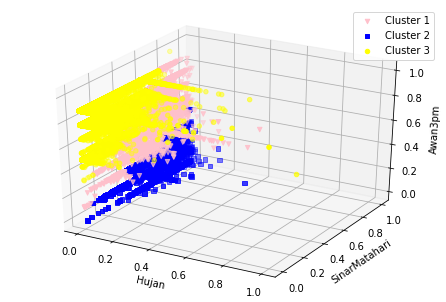

In [ ]:
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter(att7_1_1,att7_1_2,att7_1_3,color='pink', marker='v', label='Cluster 1')      #Label 1
ax.scatter(a7_1[0],a7_1[1],a7_1[2],color='red',marker='o')

ax.scatter(att7_2_1, att7_2_2, att7_2_3,color='blue', marker=',', label='Cluster 2')    #Label 2
ax.scatter(a7_2[0],a7_2[1],a7_2[2],color='red',marker='o')

ax.scatter(att7_3_1, att7_3_2, att7_3_3,color='yellow', marker='o',label='Cluster 3')   #Label 3
ax.scatter(a7_3[0],a7_3[1],a7_3[2],color='red',marker='o')

ax.set_xlabel('Hujan')
ax.set_ylabel('SinarMatahari')
ax.set_zlabel('Awan3pm')

ax.legend()

plt.show()

Attributes : KecepatanAngin3pm, Kelembaban3pm, Suhu3pm

In [ ]:
parameter = data.apply(getParameter2, axis=1)                                   #Experiment 8 : Using 3 attributes (KecepatanAngin3pm, Kelembaban3pm, & Suhu3pm) and K=3

idxa1 = randint(0,len(parameter))
idxa2 = randint(0,len(parameter))
while idxa2 == idxa1:
    idxa2 = randint(0,len(parameter))
    
idxa3 = randint(0,len(parameter))
while idxa3 == idxa1 or idxa3 == idxa2:
    idxa3 = randint(0,len(parameter))

#ITERASI PERTAMA
a8_1 = parameter[idxa1][0:3]
a8_2 = parameter[idxa2][0:3]
a8_3 = parameter[idxa3][0:3]

while True:
    for i in parameter:
        euc1, euc2, euc3 = getEuclidean(i, a8_1, a8_2, a8_3)
        i[3] = getCluster(euc1, euc2, euc3)
    prev_a1 = copy.deepcopy(a8_1)
    prev_a2 = copy.deepcopy(a8_2)
    prev_a3 = copy.deepcopy(a8_3)
    
    a8_1, a8_2, a8_3 = getNewCentroid(parameter)
    if prev_a1 == a8_1 and prev_a2 == a8_2 and prev_a3 == a8_3:
        break

att8_1_1 = []
att8_1_2 = []
att8_1_3 = []

att8_2_1 = []
att8_2_2 = []
att8_2_3 = []

att8_3_1 = []
att8_3_2 = []
att8_3_3 = []

att8 = []
cluster8 = []

for i in parameter:
    cluster8.append(i[3])
    att8.append([i[0],i[1],i[2]])
    if i[3] == 1: 
        att8_1_1.append(i[0]) 
        att8_1_2.append(i[1]) 
        att8_1_3.append(i[2]) 
    elif i[3] == 2:
        att8_2_1.append(i[0])
        att8_2_2.append(i[1])
        att8_2_3.append(i[2])
    elif i[3] == 3:
        att8_3_1.append(i[0])
        att8_3_2.append(i[1])
        att8_3_3.append(i[2])

score8 = silhouette_score(att8, cluster8)                                       #Assigning clustering and sillhouette score
print("Silhoutte Score = ", score8)
silhouette_scores.append({'K':3,'Attributes':'KecepatanAngin3pm, Kelembaban3pm, Suhu3pm','Silhouette Score':score8})      #Assigning result for evaluation viewing

Silhoutte Score =  0.30658689524395094


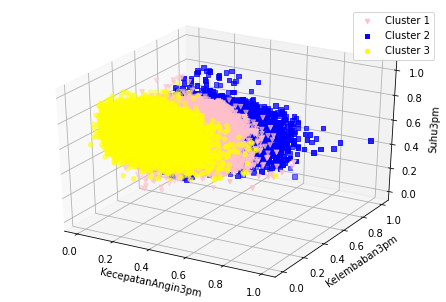

In [ ]:
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter(att8_1_1,att8_1_2,att8_1_3,color='pink', marker='v', label='Cluster 1')        #Label 1
ax.scatter(a8_1[0],a8_1[1],a8_1[2],color='red',marker='o')

ax.scatter(att8_2_1, att8_2_2, att8_2_3,color='blue', marker=',', label='Cluster 2')      #Label 2
ax.scatter(a8_2[0],a8_2[1],a8_2[2],color='red',marker='o')

ax.scatter(att8_3_1, att8_3_2, att8_3_3,color='yellow', marker='o',label='Cluster 3')     #Label 3
ax.scatter(a8_3[0],a8_3[1],a8_3[2],color='red',marker='o')

ax.set_xlabel('KecepatanAngin3pm')
ax.set_ylabel('Kelembaban3pm')
ax.set_zlabel('Suhu3pm')

ax.legend()

plt.show()

CLUSTERING RESULTS

In [ ]:
cluster_result = pd.DataFrame(silhouette_scores)                                #Assigning results of silhouette scores to new variable
pd.set_option('display.max_rows',10)                                            #Displaying tables
cluster_result